# GT box'ы изображения

In [ ]:
import matplotlib.patches as ptc
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def create_rectangles(boxes):
    rectangles = []
    for x, y, w, h in boxes:
        rectangles.append(ptc.Rectangle((x,y),w,h,linewidth=1,edgecolor='c',facecolor='none'))
    return rectangles

def show_bboxes(dataframe, path_to_img, bbox_columns):
    filename = dataframe.filename[0]
    boxes = dataframe[bbox_columns]
    rects = create_rectangles(boxes.values)
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.imshow(Image.open(path_to_img + filename))
    for i in rects:
        ax.add_patch(i)
    plt.show()

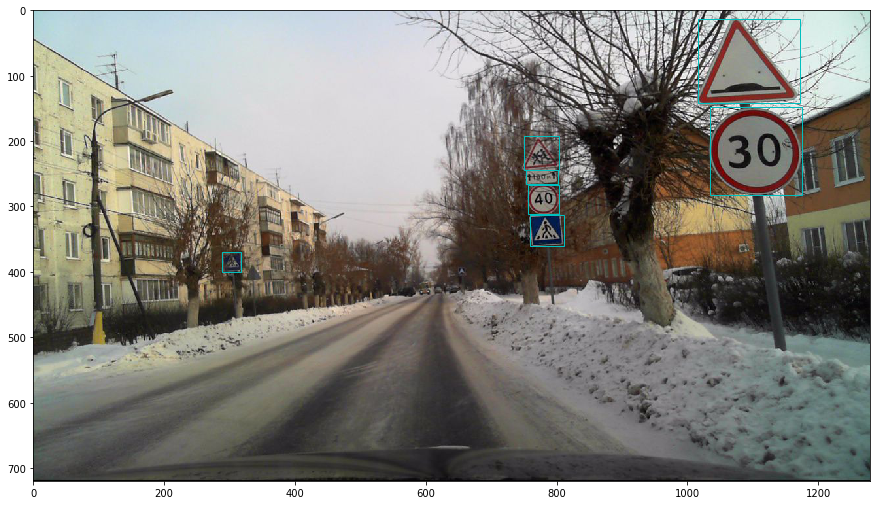

In [6]:
df = pd.read_csv('test.csv')
show_bboxes(df, '', ['x_from', 'y_from', 'width', 'height'])

# Bbox'ы изображения

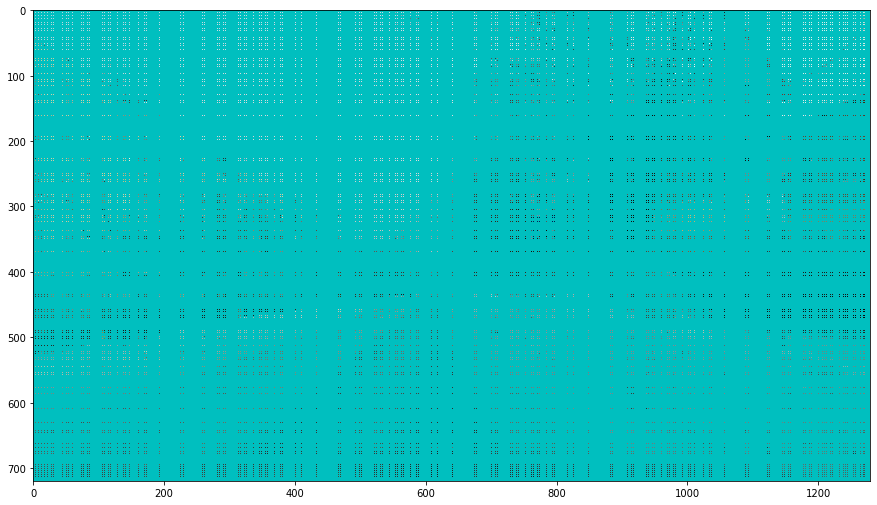

In [7]:
from sources.tools import generate_feature_map_anchor_boxes, validate_format

boxes = generate_feature_map_anchor_boxes(
    image_size=(1280, 720),
    feature_map_size=(80, 45),
    scales=[36, 64, 128],
    aspect_ratios=[0.5, 1, 2])
aligned_boxes = validate_format(boxes, from_type='center', to_type='upper_left')
rects = create_rectangles(aligned_boxes)
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.imshow(Image.open('test.jpg'))
for i in rects:
    ax.add_patch(i)
plt.show()

In [26]:
import pandas as pd
import numpy as np
import sources.tools as tls

def create_csv_with_batch(gt_df, to_df, *, image_size, feature_map_size, columns, scales, aspect_ratios):
    df = pd.read_csv('test.csv')
    gt_boxes = df[columns].values
    a_boxes = tls.generate_feature_map_anchor_boxes(
        image_size,
        feature_map_size,
        scales=scales,
        aspect_ratios=aspect_ratios
    )
    ab, ind, lab = tls.generate_batch(a_boxes, gt_boxes,
                                      boxes_format=('center', 'upper_left'),
                                      image_size=image_size,
                                      upper_threshold=0.6,
                                      track_ious=True)
    ab = tls.validate_format(ab, from_type='corners', to_type='upper_left')
    values = np.hstack((ab, ind, lab))
    new_df = pd.DataFrame(values, columns=[
        'x', 'y', 'width', 'height', 'x_t', 'y_t', 'z_t', 'label', 'iou'
    ])
    new_df.to_csv(to_df, index=False)

In [27]:
create_csv_with_batch('test.csv', 'test_batch.csv',
                      image_size=(1280, 720),
                      feature_map_size=(80, 45),
                      columns=['x_from', 'y_from', 'width', 'height'],
                      scales=[32, 64, 128],
                      aspect_ratios=[0.5, 1, 2])

In [5]:
import matplotlib.patches as ptc
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

def create_colored_rectangles(boxes):
    rectangles = []
    for x, y, w, h, c in boxes:
        color = 'm'
        if c == 2:
            color = 'c'
        elif c == 1:
            color = 'y'
        elif c == 0:
            color = 'r'
        rectangles.append(ptc.Rectangle((x,y),w,h, linewidth=1, edgecolor=color, facecolor='none'))
    return rectangles

def show_all_bboxes(gt_filepath, batch_filepath, image_path, *, columns):
    df_gt = pd.read_csv(gt_filepath)[columns]
    df_gt['label'] = 2
    gt_values = df_gt.values

    df_tr = pd.read_csv(batch_filepath)[columns]
    tr_values = df_tr.values

    boxes = np.vstack((gt_values, tr_values))

    rects = create_colored_rectangles(boxes)
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.imshow(Image.open(image_path))
    for i in rects:
        ax.add_patch(i)
    plt.show()

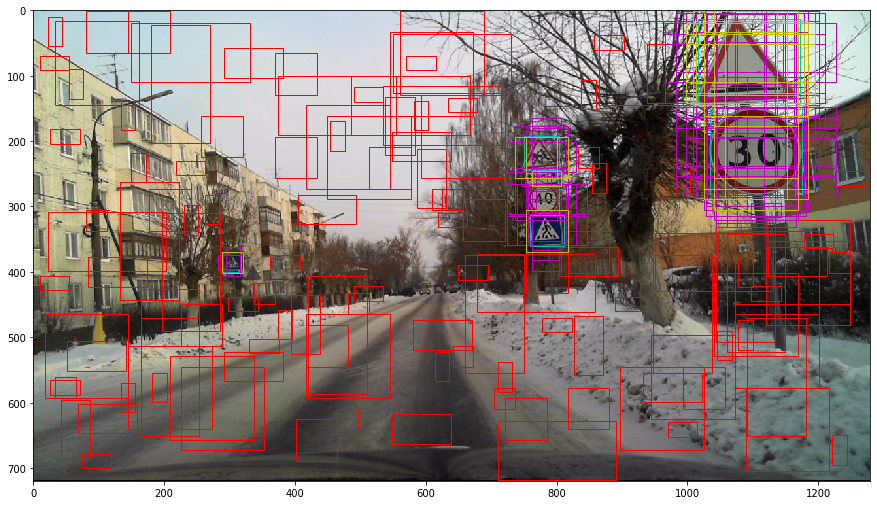

In [9]:
show_all_bboxes('tests/test.csv', 'tests/test_batch.csv', 'tests/test.jpg',
               columns=['x', 'y', 'width', 'height', 'label'])

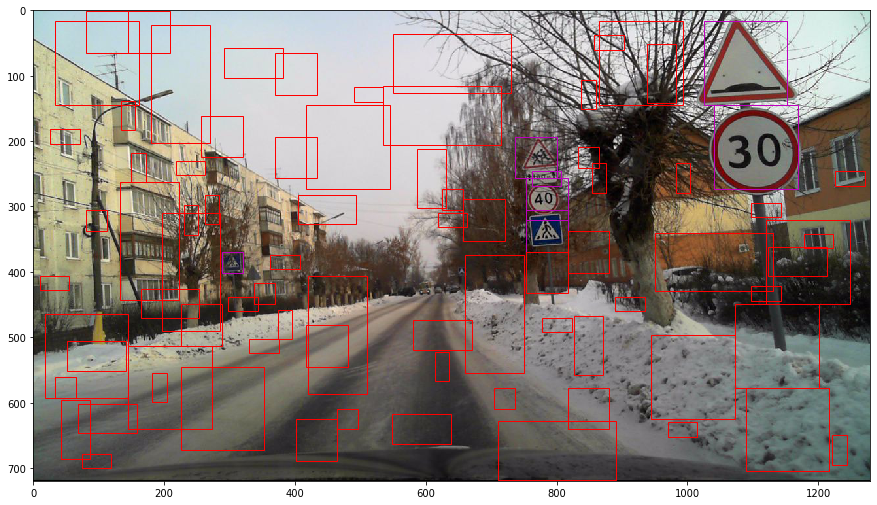

In [11]:
from sources.tools import validate_format, greedy_non_maximum_suppression
import matplotlib.patches as ptc
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

df = pd.read_csv('tests/test_batch.csv')
df = df[['x', 'y', 'width', 'height', 'label', 'iou']]
df['bg_label'] = 0
boxes, labels = greedy_non_maximum_suppression(df[['x', 'y', 'width', 'height']].values,
                                               df[['iou', 'bg_label']].values, 0.3)
boxes = validate_format(boxes, from_type='corners', to_type='upper_left')
boxes = np.hstack((boxes, labels[:, [0]]))
rects = create_colored_rectangles(boxes)
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.imshow(Image.open('tests/test.jpg'))
for i in rects:
    ax.add_patch(i)
plt.show()

In [ ]:
from sources.data_generation import split_images_dataframe

split_images_dataframe('full-gt.csv', 'dataset.csv',
                       input_path='dataset/full_frames/',
                       output_path='dataset/new_full_frames/',
                       target_size=(960, 540))